### Evaluation of Faster-RCNN FPN with and without Tracktor

The model has been trained on 25K reviewed images from Faxe. The test set are the 3 roads: _Hylleholtvej_, _Bækvej_ and _Strandvejen_ which the model has any images of during training.

In [1]:
%matplotlib inline
import os
import sys
from tqdm.notebook import tqdm
import torch

import copy
import os
import time
from os import path as osp

sys.path.insert(0, os.path.abspath('../../'))
import numpy as np
import sacred
import torch
import yaml
from sacred import Experiment
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from tracktor.config import get_output_dir
from tracktor.datasets.factory import Datasets
from tracktor.datasets.custom_wrapper import CustomSequence
from tracktor.frcnn_fpn import FRCNN_FPN
from tracktor.oracle_tracker import OracleTracker
from tracktor.reid.resnet import ReIDNetwork_resnet50
from tracktor.tracker import Tracker
from tracktor.utils import (evaluate_mot_accums, get_mot_accum,
                            interpolate_tracks, plot_sequence)

sys.path.insert(0, os.path.abspath('../../src/faster_rcnn_fpn'))

In [2]:
# Get through `make metrics`:
sys.path.append(os.path.abspath('../../metrics'))
import src.evaluators.pascal_voc_evaluator as pascal_voc_evaluator
import src.utils.converter as converter
from src.utils.enumerators import BBFormat, BBType, MethodAveragePrecision

In [3]:
from engine import train_one_epoch, evaluate
import utils

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
from google.cloud import storage
PROJECT_NAME = "pluto-a31d9"
BUCKET_NAME = "pluto-tracking-samples"
client = storage.Client(project=PROJECT_NAME)
bucket = client.get_bucket(BUCKET_NAME)

groundtruth = bucket.get_blob("3_roads_faxe_gt_annotations.csv")
model_output = bucket.get_blob("3_roads_faxe_model_output.csv")

In [5]:
import csv
import pandas as pd
from io import StringIO, BytesIO
annotations_df = pd.read_csv(StringIO(groundtruth.download_as_string().decode("utf-8")))

# Image id is in model output file:
model_output_df = pd.read_csv(StringIO(model_output.download_as_string().decode("utf-8")))

annotations_df = annotations_df.merge(
    model_output_df[['image', 'image_id']].drop_duplicates(['image_id']),
    on='image_id'
)

# "CaptureId" column is expected, we can use the`image_id` as "proxy":
annotations_df["CaptureId"] = annotations_df['image_id']

img_ids = []
img_paths = []
for i, row in annotations_df.drop_duplicates(['image_id'], keep='first').iterrows():
    capture_id = row.image_id
    img_paths.append(f"testdata/images/{row.image}")
    img_ids.append(capture_id)

In [8]:
from tracktor.utils import classes as model_labels
from custom_data import PlutoObjectDetect
import transforms as T


dataset_no_random = PlutoObjectDetect(
    img_ids, img_paths, annotations_df, bucket,
    #osp.join(data_root_dir, 'train'),
    get_transform(train=False))

In [9]:
from tracktor.frcnn_fpn import FRCNN_FPN

obj_detects = []
obj_detect_model = "../../output/custom/model_epoch_30.model"
model = FRCNN_FPN(num_classes=31)
model.load_state_dict(torch.load(obj_detect_model, map_location=lambda storage, loc: storage))
obj_detects.append(model)
model.eval()
model.cuda();

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#### Displaying image from the test set
Selecting and displaying the first image with more than 5 different labels from the test set

Finding the first image of 483 that has more than 5 labels to display variety


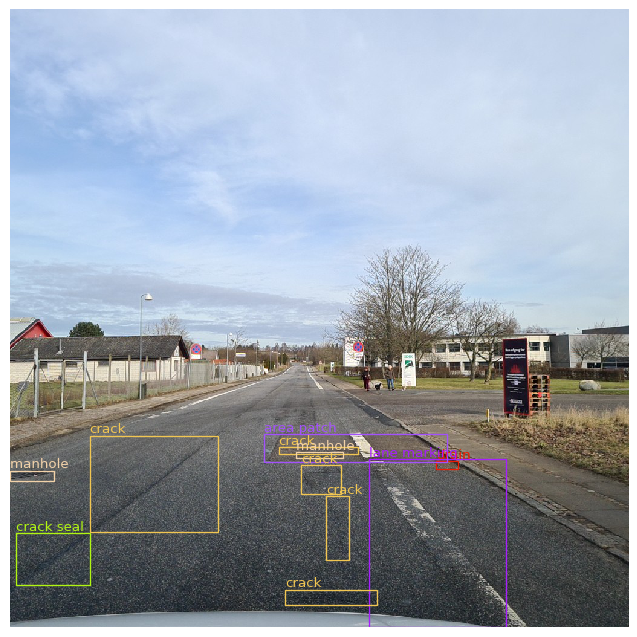

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
import transforms as T
from tracktor.utils import classes, class_index, rand_cmap

colors = rand_cmap(nlabels=len(annotations_df['ClassName'].unique()),
                   type='bright',
                   first_color_black=False)

def plot(img, boxes, labels):
    fig, ax = plt.subplots(1, dpi=96)
    
    img = img.mul(255).permute(1, 2, 0).byte().numpy()
    width, height, _ = img.shape

    ax.imshow(img, cmap=colors) #cmap='gray')
    #fig.set_size_inches(width / 80, height / 80)
    fig.set_size_inches(width / 120, height / 120)
    for label, box in zip(labels, boxes):
        #color = 1
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            fill=False,
            linewidth=1.0,
            color=colors(label))
        ax.add_patch(rect)
        plt.text(box[0], box[1] - 5, classes[class_index[str(label)]], color=colors(label))
        
    plt.axis('off')
    plt.show()

#dataset = PlutoObjectDetect(osp.join(data_root_dir, 'train'), split_seqs=['MOT17-09'])
dataset = PlutoObjectDetect(img_ids, img_paths, annotations_df, bucket)
num_labels = 5
print(f"Finding the first image of {len(dataset)} that has more than {num_labels} labels to display variety")
index = 0
for img, target in tqdm(dataset):
    if len(set(target['labels'].numpy())) > num_labels: break
    index += 1
        
#img, target = dataset[-15] #-5
img, target = T.ToTensor()(img, target)
plot(img, target['boxes'], target['labels'].numpy())

Showing the same images with model detections (without tracktor). The images are shown as-is and with non-maximum supression applied at IoU of 0.2 and 0.01 respectively. 

testdata/images/0001_e4e81487-8128-40c4-a6e2-bd693e4eeba4_img


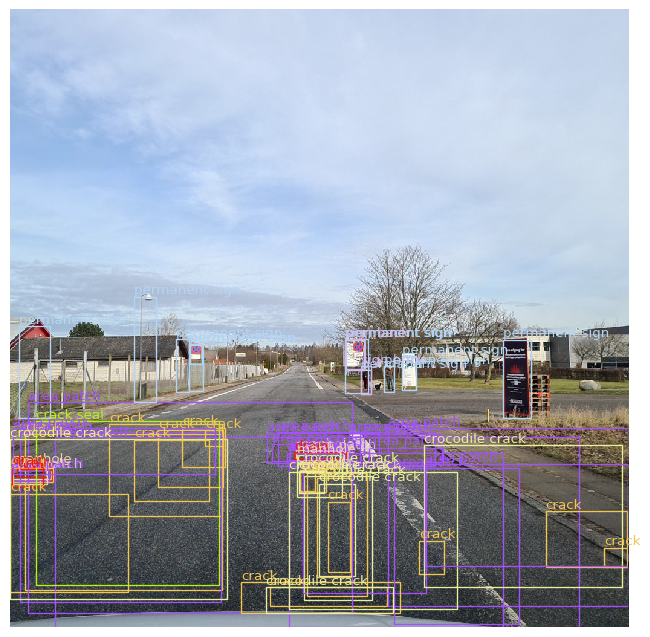

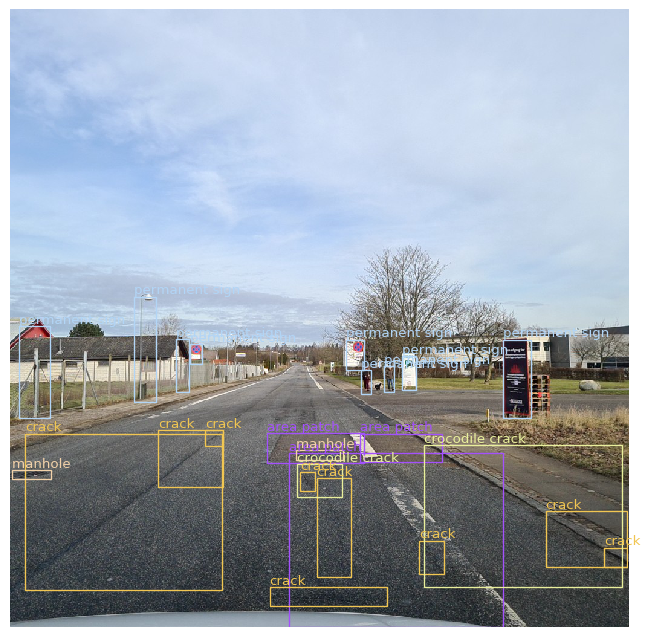

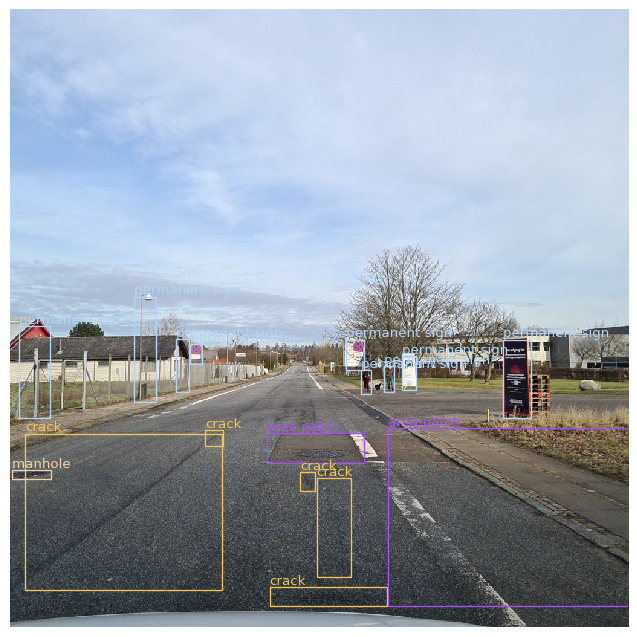

In [12]:
# pick one image from the test set
# The test sets are the images from Hylleholtvej, Strandvejen, and Bækvej
# TODO: A compatible loader for the test set 
from torchvision.ops.boxes import nms
from torch import index_select, masked_select

data_loader = torch.utils.data.DataLoader(
    dataset_no_random, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

count = -1
for imgs, target in tqdm(data_loader):
    count += 1
    if count != index: continue
    print(dataset_no_random._img_paths[0])

    model.eval()
    with torch.no_grad():
        prediction = model([imgs[0].to(device)])[0]
    
    # Without non-maximum supression: 
    plot(imgs[0], prediction['boxes'].cpu(), prediction['labels'].cpu().numpy())
   
    # With 0.2 IoU based non-maximum supression applied
    indices = nms(prediction['boxes'], prediction['scores'], 0.2)
    plot(imgs[0], prediction['boxes'][indices].cpu(), prediction['labels'][indices].cpu().numpy())
     
    # With 0.01 IoU based non-maximum supression applied
    indices = nms(prediction['boxes'], prediction['scores'], 0.01)
    plot(imgs[0], prediction['boxes'][indices].cpu(), prediction['labels'][indices].cpu().numpy())
    
    # Groundtruth
    #plot(imgs[0], target[0]['boxes'], target[0]['labels'].cpu().numpy())
    break

### Generating model output without tracktor
Output is stored in Pascal VOC format and we're using [Object Detecting metrics](https://github.com/rafaelpadilla/review_object_detection_metrics) to evaluate the mAP scores. 

In [13]:
for imgs, target in tqdm(data_loader):
    model.eval()
    with torch.no_grad():
        prediction = model([imgs[0].to(device)])[0]
        
    # xyrb pascal VOC format:
    # <class_name> <confidence> <left> <top> <right> <bottom> 
    img_id = img_ids[target[0]['image_id']]
    with open(f"../../output/custom/faster_rcnn_fpn/testing/{img_id}.txt", 'w') as f:
        for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
            x1, y1, x2, y2 = box.cpu().numpy()
            f.write(f"{class_index[str(label.item())]} {score} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n")

In [17]:
#del model # release
torch.cuda.empty_cache()

In [18]:
import glob
dir_gts = '../../data/gt/*txt'
dir_dets = '../../output/custom/faster_rcnn_fpn/testing/*txt'
gts = glob.glob(dir_gts)
detections = glob.glob(dir_dets)

In [19]:
labels = annotations_df['label'].unique().tolist()
# Adding none for the confusion matrix
labels.append('None')
l_num = len(labels)
label_to_ind = {labels[i]: i for i in range(l_num)}
conf_matrix = [[0 for i in range(l_num)] for j in range(l_num)]

#gets the Intersection over Union of two boxes
def calculateIOU(box1, box2):
    x11, y11, x21, y21 = box1[:4]
    x12, y12, x22, y22 = box2[:4]

    yi1 = max(y11, y12)
    xi1 = max(x11, x12)
    yi2 = min(y21, y22)
    xi2 = min(x21, x22)
    inter_area = max(((xi2 - xi1) * (yi2 - yi1)), 0)
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (x21 - x11) * (y21 - y11)
    box2_area = (x22 - x12) * (y22 - y12)
    union_area = box1_area + box2_area - inter_area
    # compute the IoU
    if union_area == 0:
        return 2
    iou = inter_area / union_area
    return iou

def box_area(box):
    return (box[1] - box[0]) * (box[3] - box[2])

In [20]:
label_to_ind

{'R30': 0,
 'M10': 1,
 'M20': 2,
 'D10': 3,
 'R10': 4,
 'D20': 5,
 'R20': 6,
 'P20': 7,
 'S10': 8,
 'M30': 9,
 'A10': 10,
 'D40': 11,
 'S30': 12,
 'D50': 13,
 'D30': 14,
 'D41': 15,
 'F20': 16,
 'D70': 17,
 'A20': 18,
 'D80': 19,
 'D60': 20,
 'None': 21}

In [21]:
iou_thresh = 0.5
det_thresh = 0.5
print(len(gts))
for i in range(len(gts)):
    
    tp_1, fp_1, tn_1, fn_1 = 0, 0, 0, 0
    ground = gts[i]
    detect = detections[i]
    
    g_df = pd.read_csv(ground, sep=" ", header = None).values
    d_df = [dts.tolist() for dts in pd.read_csv(detect, sep=" ", header = None).values if dts[1] >= 0.5]
    for g in g_df:
        g_label, g_box = g[0], g[1:]
        if len(d_df) == 0:
            conf_matrix[label_to_ind[g_label]][-1] += 1
            continue
        biggest = max(d_df, key = lambda dts: calculateIOU(dts[2:], g_box))    
        d_df.remove(biggest)
        conf_matrix[label_to_ind[g_label]][label_to_ind[biggest[0]]] += 1 
      
    for d in d_df:
        conf_matrix[-1][label_to_ind[d[0]]] += 1 

483


In [22]:
conf_matrix

[[0, 9, 0, 73, 11, 7, 1, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 112],
 [0, 13, 0, 17, 16, 2, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 37],
 [0, 1, 0, 21, 19, 3, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21],
 [0, 12, 0, 470, 84, 62, 7, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 196],
 [0, 7, 0, 41, 76, 7, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 34],
 [0, 2, 0, 69, 28, 269, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31],
 [0, 2, 0, 6, 13, 1, 7, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12],
 [0, 0, 0, 2, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4],
 [0, 1, 0, 14, 5, 3, 2, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11],
 [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 5, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
 [0, 0, 0, 3, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
 [0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 6, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4],
 

Confusion matrix, without normalization


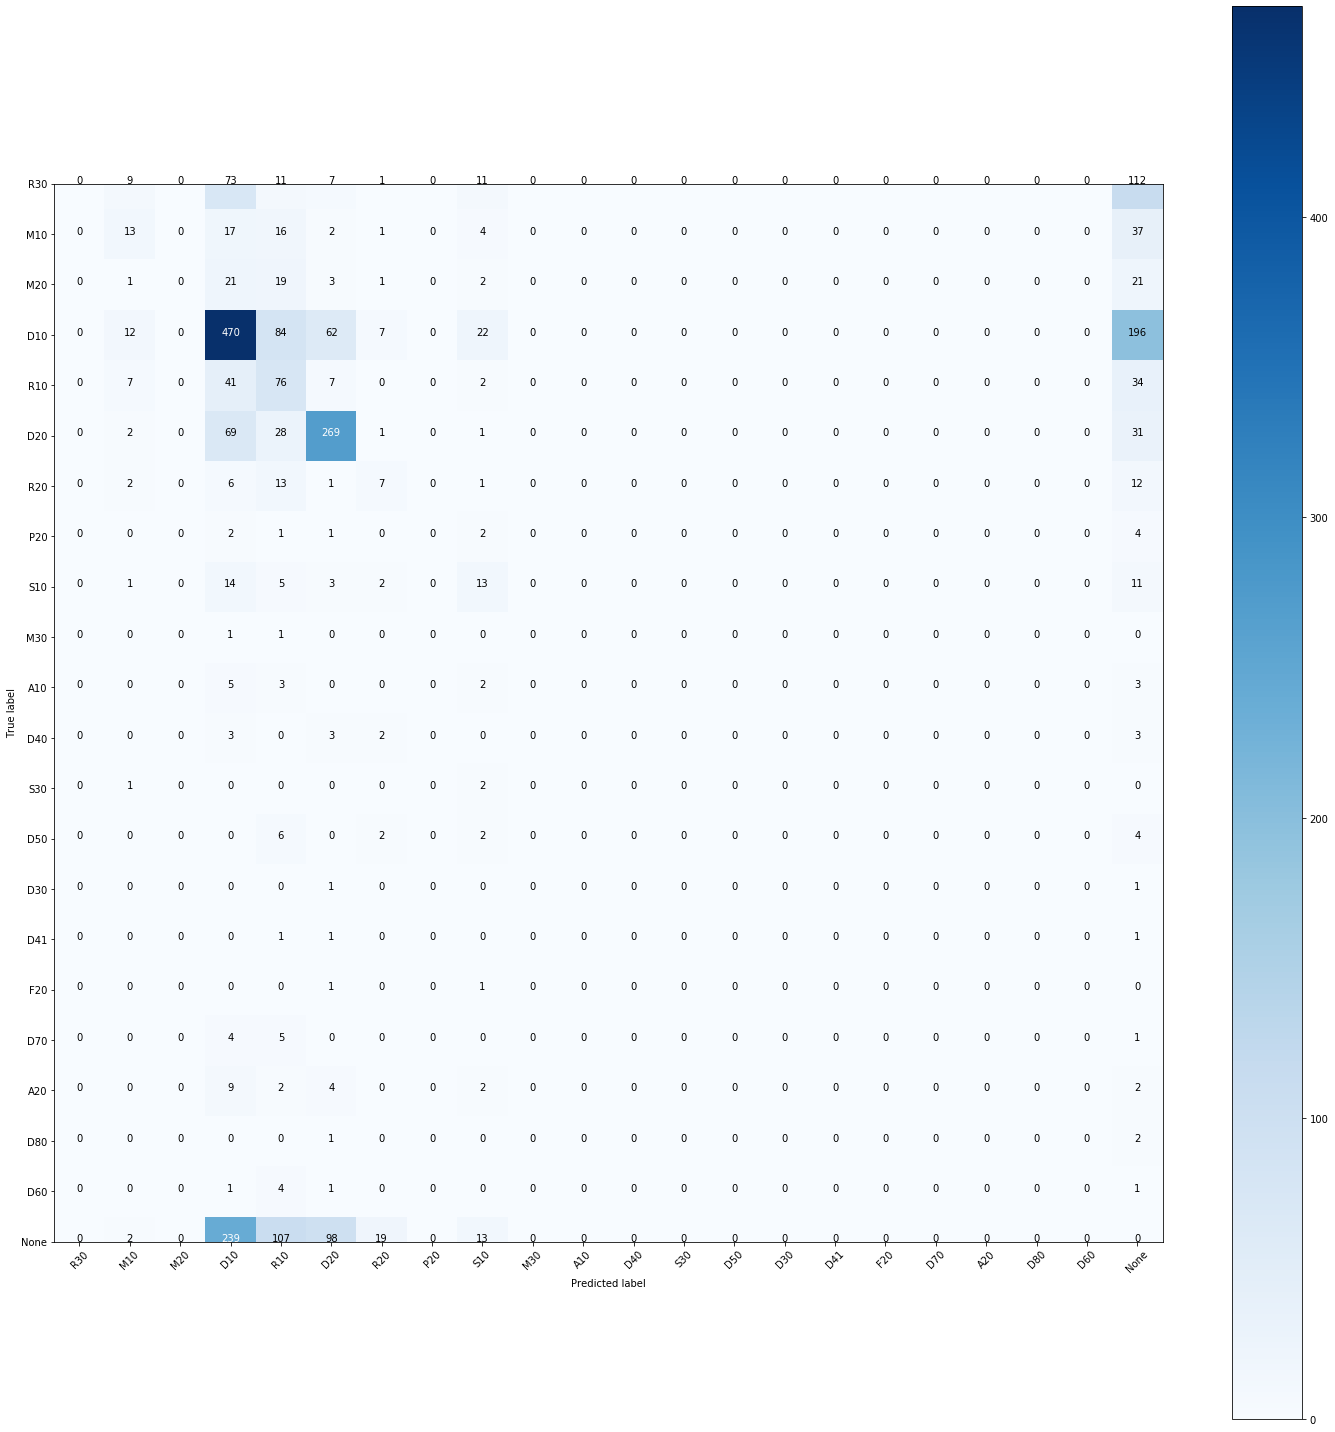

In [24]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = np.max(cm) / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize = (20,20))
plot_confusion_matrix(np.array(conf_matrix), classes=labels,
                      title='Confusion matrix, without normalization')

### Model with Tracktor
Rerunning the experiment but now with Tracktor. 

> **Note**: Non of what the paper mentions as _extensions_ are applied

In [70]:
obj_detects = []
obj_detect_model = "../../output/custom/model_epoch_30.model"
obj_detect = FRCNN_FPN(num_classes=31)
obj_detect.load_state_dict(torch.load(obj_detect_model, map_location=lambda storage, loc: storage))
obj_detects.append(obj_detect)
obj_detect.eval()
obj_detect.cuda();

tracker_conf = {
  "detection_person_thresh": 0.4,
  "regression_person_thresh": 0.001,
  "detection_nms_thresh": 0.05,
  "regression_nms_thresh": 0.5,
  "motion_model" : {
    "enabled": True,
    "n_steps": 5,
    "center_only": True
  },
  "public_detections": False,
  "do_align": True,
  "warp_mode": "MOTION_EUCLIDEAN",
  "number_of_iterations": 100,
  "termination_eps": 0.00001,
  "do_reid": False,
  "inactive_patience": 50,
  "max_features_num": 10,
  "reid_sim_threshold": 2.0,
  "reid_iou_threshold": 0.2
}

In [71]:
from tracktor.datasets.evaluation_wrapper import evaluationSequence

def fill_tracktor(name):
    torch.cuda.empty_cache()
    result_dir = "../../output/custom/results"
    seq = evaluationSequence(name, result_dir, annotations_df)
    data_loader = DataLoader(seq, batch_size=1, shuffle=False)
    tracker = Tracker(obj_detect, [], tracker_conf)
    tracker.reset()
    
    for i, frame in enumerate(tqdm(data_loader, leave=True, position=0)):
        with torch.no_grad():
            tracker.step(frame, -1)

    results = tracker.get_results()
    results = interpolate_tracks(results)
    seq.write_results(results)
    model_output = pd.read_csv("../../output/custom/results/" + name +".csv",header=None)
    model_output.columns = ["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height", "confidence", "x", "y", "z", "label_index", 'image_name']
    for row in model_output.values:
        img_id = row[-1][5:-4]
        with open(f"../../output/custom/faster_rcnn_fpn/testing/{img_id}.txt", 'a') as f:
            x1 = row[2] - 1
            y1 = row[3] - 1
            x2 = row[4] - 1 + x1
            y2 = row[5] - 1 + y1
            score = row[6]
            label = row[10]
            f.write(f"{class_index[str(label)]} {score} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n")

In [72]:
names = ['bækvej_faxe', 'hylleholtvej_faxe', 'strandvejen_faxe']
for name in names:
    fill_tracktor(name)

KeyboardInterrupt: 

In [ ]:
dir_gts = '../../data/gt/'
dir_dets = '../../output/custom/faster_rcnn_fpn/testing/'
gt_bbs = converter.text2bb(dir_gts, bb_type=BBType.GROUND_TRUTH, bb_format=BBFormat.XYX2Y2)
det_bbs = converter.text2bb(dir_dets, bb_type=BBType.DETECTED, bb_format=BBFormat.XYX2Y2)

ious = [0.01, 0.2, 0.5, 0.75]
voc_res = {}
for iou in ious:
    res = pascal_voc_evaluator.get_pascalvoc_metrics(gt_bbs, det_bbs, iou, generate_table=True, method=MethodAveragePrecision.EVERY_POINT_INTERPOLATION)
    voc_res[iou], mAP = res['per_class'], res['mAP'] 
    #pascal_voc_evaluator.plot_precision_recall_curves(voc_res[iou], showInterpolatedPrecision=True, showAP=True)

    print(f"Mean average precision (mAP): {mAP} at IoU threshold {iou}")

In [ ]:
import glob
dir_gts = '../../data/gt/*txt'
dir_dets = '../../output/custom/faster_rcnn_fpn/testing/*txt'
gts = glob.glob(dir_gts)
detections = glob.glob(dir_dets)

In [ ]:
len(detections)

In [ ]:
labels = annotations_df['label'].unique().tolist()
# Adding none for the confusion matrix
labels.append('None')
l_num = len(labels)
label_to_ind = {labels[i]: i for i in range(l_num)}
conf_matrix = [[0 for i in range(l_num)] for j in range(l_num)]

In [ ]:
ou_thresh = 0.5
det_thresh = 0.5
print(len(gts))
for i in range(len(detections)):
    
    tp_1, fp_1, tn_1, fn_1 = 0, 0, 0, 0
    ground = gts[i]
    detect = detections[i]
    
    g_df = pd.read_csv(ground, sep=" ", header = None).values
    d_df = [dts.tolist() for dts in pd.read_csv(detect, sep=" ", header = None).values if dts[1] >= 0.5]
    for g in g_df:
        g_label, g_box = g[0], g[1:]
        if len(d_df) == 0:
            conf_matrix[label_to_ind[g_label]][-1] += 1
            continue
        biggest = max(d_df, key = lambda dts: calculateIOU(dts[2:], g_box))    
        d_df.remove(biggest)
        conf_matrix[label_to_ind[g_label]][label_to_ind[biggest[0]]] += 1 
      
    for d in d_df:
        conf_matrix[-1][label_to_ind[d[0]]] += 1 

In [ ]:
plt.figure(figsize = (20,20))
plot_confusion_matrix(np.array(conf_matrix), classes=labels,
                      title='Confusion matrix, without normalization')